In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [ ]:
def f(t, u: np.array) -> np.array:
    """
    RHS of the system
    """
    return np.array([u[1], -u[0]])

In [49]:
def legendre_polynomial_basis(n: int, x: float) -> np.array:
    """
    Creates the Legendre polynomial basis up to degree n-1.

    Parameters:
        n (int): Degree to which the Legendre polynomial is evaluated.
        x (float): Point at which the Legendre polynomial is evaluated.

    Returns:
        np.array: Bases of the Legendre polynomial at x.
    """
    basis = np.zeros(n)
    if n >= 1:
        basis[0] = 1.0
    if n >= 2:
        basis[1] = x
        for i in range(2, n):
            basis[i] = (2*i - 1)/i * x * basis[i-1] - (i - 1)/i * basis[i-2]
    return basis


def legendre_polynomial(n: int, point: float) -> float:
    """
    Evaluates the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the Legendre polynomial is evaluated.
        x (float): Point at which the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the n-th Legendre polynomial at x.
    """
    value = legendre_polynomial_basis(n + 1, point)[n]
    return value


def legendre_derivative(n: int, x: float) -> float:
    """
    Evaluates the derivative of the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the derivative of the Legendre polynomial is evaluated.
        x (float): Point at which the derivative of the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the derivative of tghe n-th Legendre polynomial at x.
    """
    if n == 0:
        return 0.0
    Pn = legendre_polynomial(n, x)
    Pn_1 = legendre_polynomial(n - 1, x)
    return n / (x**2 - 1.0) * (x * Pn - Pn_1)


In [ ]:
def legendre_quadrature(integrand, m: int = 32) -> float:
    """
    Computes the Gauss-Legendre of a given function with arbitrary precision.

    Parameters:
        integrand (callable): Function to be integrated.
        m (int, optional): Degree of the quadrature.

    Returns:
        float: Value of the integral.
    """
    pts, wts = np.polynomial.legendre.leggauss(m)
    vals = np.array([integrand(x) for x in pts])
    return np.sum(wts * vals)


def legendre_quadrature_vec(integrand, m: int = 32, d: int | None = None) -> np.array:
    """
    Vector-valued Gauss-Legendre quadrature for each component.

    Parameters:
        integrand (callable): Vector-valued function.
        m (int): Degree of the quadrature.
        d (int): Dimension of output.

    Returns:
        np.array: Integral values per component.
    """
    if d is None:
        d = int(integrand(0.0).size)
    comps = []
    for k in range(d):
        def comp_fun(s, k=k):
            return integrand(s)[k]
        comps.append(legendre_quadrature(comp_fun, m=m))
    return np.array(comps)

In [ ]:
def affine_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [-1,1] to [a,b]

    Parameters:
        x (np.array): Interval from [-1,1]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [a,b].
    """
    return (b-a)/2 * x + (a+b)/2


def build_vandermonde(s_grid: np.array, n: int) -> np.array:
    """
    Builds Vandermonde Matrix to interpolate solution

    Parameters:
        s_grid (np.array): Points at which the Vandermonde matrix is evaluated
        n (int): Number of coefficients for the Legendre Basis

    Returns:
        np.array: Values of the interpolating polynomial.
    """
    V = np.empty((s_grid.size, n))
    for i, s in enumerate(s_grid):
        for j in range(n):
            V[i, j] = legendre_polynomial(j, s)
    return V


def jacobian(f, t: float, u: np.ndarray, h: float = 1e-8) -> np.ndarray:
    n = u.size
    J = np.zeros((n, n))
    for k in range(n):
        e = np.zeros(n)
        e[k] = 1.0
        fp = f(t, u + h * e)
        fm = f(t, u - h * e)
        J[:, k] = (fp - fm) / (2.0 * h)
    return J


def make_u_interp(t_grid: np.ndarray, u_grid: np.ndarray):
    def u_interp(t: float) -> np.ndarray:
        d = u_grid.shape[1]
        vals = np.zeros(d)
        for k in range(d):
            vals[k] = np.interp(t, t_grid, u_grid[:, k])
        return vals
    return u_interp


def dual_rhs_factory(f, u_interp):
    def g(t: float, z: np.ndarray) -> np.ndarray:
        u_t = u_interp(t)
        J = jacobian(f, t, u_t)
        return - J.T @ z
    return g

J_test = jacobian(f, 1.0, np.array([2.0, 2.0]))
print(J_test)

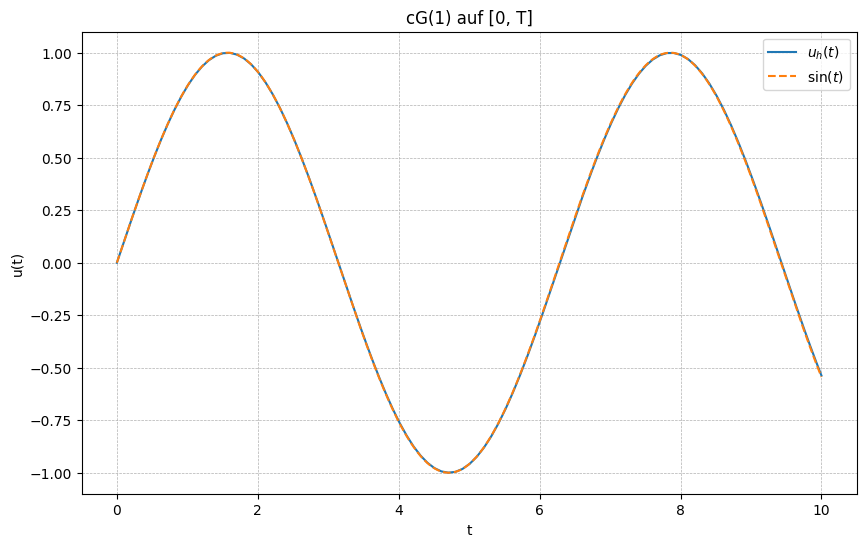

In [ ]:
def make_interval_residual(f, n: int, u_initial: np.array, t_n: float, dt: float, quad_m: int = 64, return_r_fun: bool = False):
    """
    Vector residual for one time interval using affine transformation to reference element [-1,1].

    Parameters:
        f (callable): RHS function, returns np.array of shape (d,).
        n (int): Number of dofs per interval (Legendre basis size).
        u_initial (np.array): Initial value u(t_n) used as continuity constraint at s = -1.
        t_n (float): Left endpoint time of the interval.
        dt (float): Time step size.
        quad_m (int): Gauss-Legendre quadrature degree.
        return_r_fun (bool): When True, also returns a builder that maps coefficients to r_fun(s).

    Returns:
        tuple: (residual(c_flat), r_fun_from_c):
        - residual: System residual used by the nonlinear solver
        - r_fun_from_c: Function that accepts coefficients array (n,d) and returns r_fun(s) (for adaptive method)
    """
    alpha = 2.0 / dt
    t_np1 = t_n + dt
    d = int(u_initial.size)

    def residual(c_flat: np.array) -> np.array:
        c = c_flat.reshape(n, d)
        r = np.zeros((n, d))
        for i in range(n - 1):
            def integrand(s: float) -> np.array:
                t_val = affine_trafo(np.array([s]), t_n, t_np1)[0]
                u_val = np.zeros(d)
                du_val = np.zeros(d)
                for j in range(n):
                    Pj = legendre_polynomial(j, s)
                    dPj = legendre_derivative(j, s)
                    u_val += c[j, :] * Pj
                    du_val += c[j, :] * dPj
                return (alpha * du_val - f(t_val, u_val)) * legendre_polynomial(i, s)
            r[i, :] = legendre_quadrature_vec(integrand, m=quad_m, d=d)
        u_boundary = np.zeros(d)
        for j in range(n):
            u_boundary += c[j, :] * legendre_polynomial(j, -1.0)
        r[-1, :] = u_boundary - u_initial
        return r.reshape(n * d)

    def r_fun_from_c(c: np.ndarray):
        c = np.asarray(c).reshape(n, d)
        def r_fun(s: float) -> np.ndarray:
            t_val = affine_trafo(np.array([s]), t_n, t_np1)[0]
            u_val = np.zeros(d)
            du_val = np.zeros(d)
            for j in range(n):
                Pj = legendre_polynomial(j, s)
                dPj = legendre_derivative(j, s)
                u_val += c[j, :] * Pj
                du_val += c[j, :] * dPj
            return alpha * du_val - f(t_val, u_val)
        return r_fun

    if return_r_fun:
        return residual, r_fun_from_c
    return residual


def solve_cG_time(f, u0: np.ndarray, T: float, N: int, n_dofs: int, quad_m: int = 64, grid: int = 100) -> tuple:
    """
    Solve u'(t) = f(u(t)) on [0, T] via piecewise cG in time for systems of size d.

    Parameters:
        f (callable): RHS function f(u) returning.
        u0 (np.ndarray): Initial value u(0).
        T (float): Final time.
        N (int): Number of time intervals.
        n_dofs (int): Legendre basis size per interval.
        quad_m (int): Quadrature degree per interval.
        grid (int): Number of interpolation points per interval.

    Returns:
        (t_all, u_all): Time grid and solution values.
    """
    t_nodes = np.linspace(0.0, T, N + 1)
    t_all = []
    u_all = []
    u_left = u0.copy()
    d = u0.size

    for k in range(N):
        t_n, t_np1 = t_nodes[k], t_nodes[k + 1]
        dt = t_np1 - t_n
        residual = make_interval_residual(f, n_dofs, u_left, t_n, dt, quad_m=quad_m, return_r_fun=False)
        x0 = np.zeros((n_dofs, d))
        x0[0, :] = u_left
        c_flat = scipy.optimize.fsolve(residual, x0.reshape(n_dofs * d), xtol=1e-8)
        c = c_flat.reshape(n_dofs, d)
        s_grid = np.linspace(-1.0, 1.0, grid)
        V = build_vandermonde(s_grid, n_dofs)
        u_vals = V @ c
        t_grid = affine_trafo(s_grid, t_n, t_np1)
        if k == 0:
            t_all.extend(t_grid.tolist())
            u_all.extend(u_vals.tolist())
        else:
            t_all.extend(t_grid[1:].tolist())
            u_all.extend(u_vals[1:].tolist())
        u_right = np.zeros(d)
        for j in range(n_dofs):
            u_right += c[j, :] * legendre_polynomial(j, 1.0)
        u_left = u_right
    return np.array(t_all), np.array(u_all)


t_all, U_all = solve_cG_time(
    f,
    u0=np.array([0.0, 1.0]),
    T=10.0,
    N=100,
    n_dofs=2,
    quad_m=64,
    grid=100,
)

u1_exact = np.sin(t_all)

plt.figure(figsize=(10, 6))
plt.plot(t_all, U_all[:, 0], label="$u_h(t)$")
plt.plot(t_all, u1_exact, '--', label="$\\sin(t)$")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("cG(1) auf [0, T]")
plt.show()

In [53]:
# RK4-Methode
T = np.linspace(0, 20, 1000)
A = np.array([
    [0, 0, 0, 0],
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 1, 0]
])
b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1])


def runge_kutta(f: callable, initialwert: np.ndarray, T: np.ndarray, A: np.array, b, c) -> np.ndarray:
    s = A.shape[0]
    n = T.shape[0]
    y = np.zeros((n, len(initialwert)))
    y[0] = initialwert

    for m in range(n-1):
        h = T[m+1]-T[m]
        k = np.zeros((s,len(initialwert)))

        for i in range (0, s):
            k[i] = f(T[m] + c[i] * h, y[m] + h * A[i, :] @ k[:])

        y[m+1] = y[m] + h * b[:] @ k[:]

    return y

[ 0.          0.00029707  0.00059401 ... -0.17955064 -0.17895031
 -0.17833621]
[ 0.00000000e+00  2.73834774e-14  5.47669549e-14 ... -4.58657556e-11
 -4.57427429e-11 -4.56183979e-11]


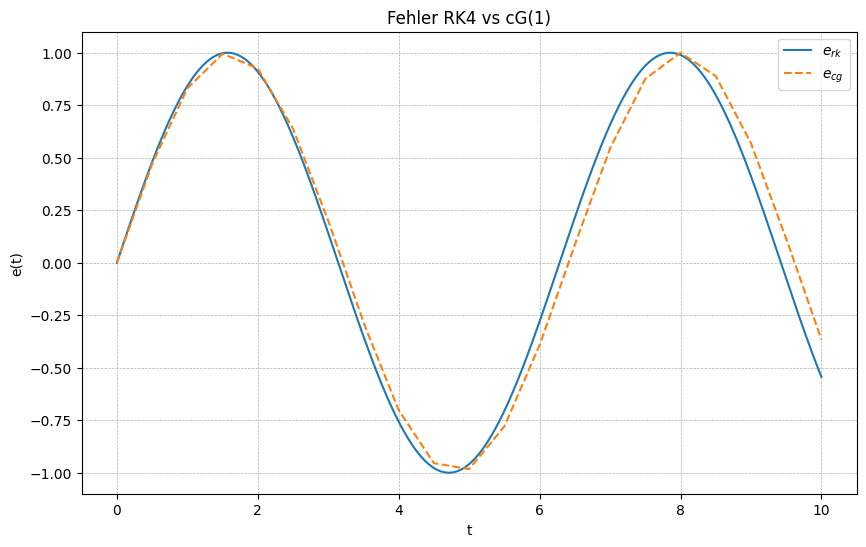

In [54]:
u0 = np.array([0.0, 1.0])

t, u_cg = solve_cG_time(
    f,
    u0,
    T=10.0,
    N=20,
    n_dofs=2,
    quad_m=64,
    grid=100,
)

u_rk = runge_kutta(f, u0, t, A, b, c)

u1_exact = np.sin(t)

error_rk = u1_exact - u_rk[:, 0]
error_cg = u1_exact - u_cg[:, 0]
print(error_cg)
print(error_rk)

plt.figure(figsize=(10, 6))
plt.plot(t, u_rk[:,0], label="$e_{rk}$")
plt.plot(t, u_cg[:,0], '--', label="$e_{cg}$")
#plt.plot(t, u1_exact, label='$u(t)$')
plt.xlabel("t")
plt.ylabel("e(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("Fehler RK4 vs cG(1)")
plt.show()

global error=6.908e-02, iter=1
[adapt] ind=1.486e-05, h=6.250e-01, t=0.000e+00
[adapt] ind=1.484e-05, h=6.250e-01, t=6.250e-01
[adapt] ind=1.483e-05, h=6.250e-01, t=1.250e+00
[adapt] ind=1.483e-05, h=6.250e-01, t=1.875e+00
[adapt] ind=1.483e-05, h=6.250e-01, t=2.500e+00
[adapt] ind=1.481e-05, h=6.250e-01, t=3.125e+00
[adapt] ind=1.481e-05, h=6.250e-01, t=3.750e+00
[adapt] ind=1.480e-05, h=6.250e-01, t=4.375e+00
[adapt] ind=1.481e-05, h=6.250e-01, t=5.000e+00
[adapt] ind=1.479e-05, h=6.250e-01, t=5.625e+00
[adapt] ind=1.479e-05, h=6.250e-01, t=6.250e+00
[adapt] ind=1.478e-05, h=6.250e-01, t=6.875e+00
[adapt] ind=1.479e-05, h=6.250e-01, t=7.500e+00
[adapt] ind=1.477e-05, h=6.250e-01, t=8.125e+00
[adapt] ind=1.476e-05, h=6.250e-01, t=8.750e+00
[adapt] ind=1.476e-05, h=6.250e-01, t=9.375e+00
[sanity] T=10.0
[0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125
 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125
 0.3125 0.3125 0.3125 0.3125 0.3125 0.3125 

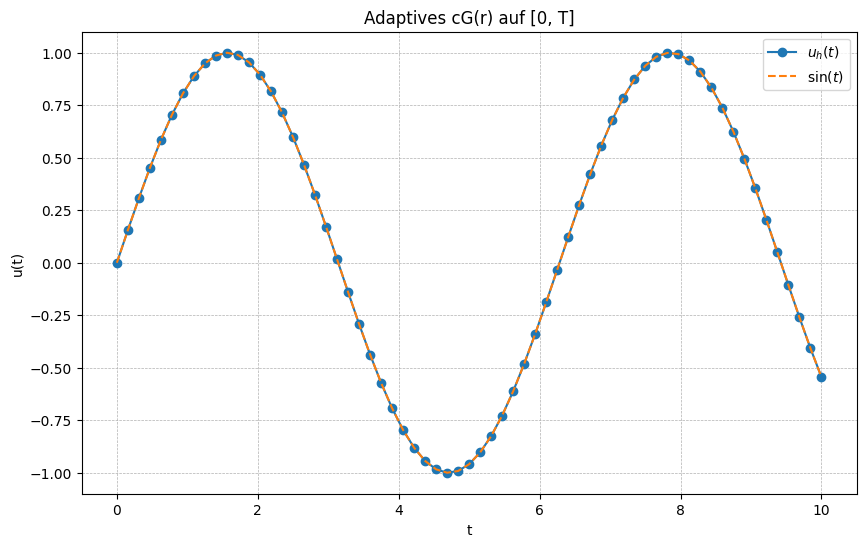

In [ ]:
def solve_cG_step(f, u0: np.ndarray, t_node: np.array, n_dofs: int, quad_m_res: int = 12):
    """
    Solve u'(t) = f(u(t)) on [t_{n-1}, t_n] via piecewise cG in time for systems of size d.

    Parameters:
        f (callable): RHS function f(u) returning.
        u0 (np.ndarray): Initial value u(t_{n-1}).
        tnode (np.array): Time interval.
        n_dofs (int): Legendre basis size per interval.
        quad_m_res (int): Reduced quadrature degree for interval.

    Returns:
        (u_interval, r_fun): Solution on interval and residual function for error.
    """
    d = u0.size
    t_n, t_np1 = t_node[0], t_node[1]
    h = t_np1 - t_n

    residual, r_fun_from_c = make_interval_residual(
        f, n_dofs, u0, t_n, h, quad_m=quad_m_res, return_r_fun=True
    )
    x0 = np.zeros((n_dofs, d))
    x0[0, :] = u0
    c_flat = scipy.optimize.fsolve(residual, x0.reshape(n_dofs * d), xtol=1e-8, maxfev=400)
    c = c_flat.reshape(n_dofs, d)

    u_left = u0.copy()
    u_right = np.zeros(d)
    for j in range(n_dofs):
        u_right += c[j, :] * legendre_polynomial(j, 1.0)
    u_interval = np.vstack([u_left, u_right])

    r_fun = r_fun_from_c(c)

    return u_interval, r_fun


def solve_cG_grid(f, u0: np.ndarray, t_grid: np.array, n_dofs: int, quad_m: int = 64, grid: int = 100):
    """
    Solve u'(t) = f(u(t)) on [0, T] via piecewise cG in time for systems of size d with a custom (non-uniform) grid.

    Parameters:
        f (callable): RHS function f(u) returning.
        u0 (np.ndarray): Initial value u(0) with.
        t_grid (np.array): Custom time grid.
        n_dofs (int): Legendre basis size per interval.
        quad_m (int): Quadrature degree for interval.
        grid (int): Number of interpolation points per interval.

    Returns:
        u_all: Solution on the entire time grid.
    """
    u_all = [u0.tolist()]
    for i in range(t_grid.size-1):
        tnode = np.array([t_grid[i], t_grid[i+1]])
        u_interval, _ = solve_cG_step(f, u0=u0, t_node=tnode, n_dofs=n_dofs, quad_m_res=min(quad_m, 12), grid=grid)
        u0 = u_interval[1, :]
        u_all.append(u0.tolist())
    return np.array(u_all)


def adaptive_cg_method(f, u0: np.ndarray, h: float, t0: float, T: float, n_dofs: 
                       int, quad_m: int = 64, grid: int = 100, TOL: float = 1e-7, max_iter: int = 20) -> np.array:
    """
    """
    N = max(1, int((T - t0) / h))
    t_coarse, u_coarse = solve_cG_time(f, u0=u0, T=T, N=N, n_dofs=n_dofs, quad_m=quad_m, grid=grid)
    t_half, u_half = solve_cG_time(f, u0=u0, T=T, N=2*N, n_dofs=n_dofs, quad_m=quad_m, grid=grid)
    h_vec = np.diff(t_half)
    it = 0

    while np.linalg.norm(u_half[-1, :] - u_coarse[-1, :]) > TOL and it < max_iter:
        it += 1
        new_hvec_list = []

        print(f"global error={np.linalg.norm(u_half[-1, :] - u_coarse[-1, :]):.3e}, iter={it}")
        h_vec = np.diff(t_half)

        u_interp = make_u_interp(t_half, u_half)
        dual_problem = dual_rhs_factory(f, u_interp)
        diff = u_half[-1, :] - u_coarse[-1, :]
        z0 = diff / np.linalg.norm(diff)
        z = runge_kutta(dual_problem, z0, t_half, A, b, c)

        t0_temp = t0
        for i in range(h_vec.size):
            h_n = h_vec[i]
            tnode = np.array([t0_temp, t0_temp+h_n])

            u_interval, r_fun = solve_cG_step(f, u0=u_half[i], t_node=tnode, n_dofs=n_dofs, quad_m_res=min(quad_m, 12), grid=grid)

            resid_sq_vec = legendre_quadrature_vec(lambda s: r_fun(s)**2, m=quad_m, d=u_interval.shape[1])
            resid_L2 = float(np.sqrt((h_n / 2.0) * np.sum(resid_sq_vec)))

            z_weight = np.linalg.norm(z[i])
            indicator = resid_L2 * z_weight * h_n

            if indicator > TOL:
                new_hvec_list.append(h_n / 2.0)
                new_hvec_list.append(h_n / 2.0)
            elif indicator < 0.25*TOL:
                if i+1 < h_vec.size:
                    new_hvec_list.append(h_n + h_vec[i+1])
                else:
                    new_hvec_list.append(h_n)
            else:
                new_hvec_list.append(h_n)

            print(f"[adapt] ind={indicator:.3e}, h={h_n:.3e}, t={t0_temp:.3e}")
            t0_temp += h_n

        h_vec = np.array(new_hvec_list)
        sanity_check = 0
        for j in range(h_vec.size):
            if sanity_check < T:
                sanity_check += h_vec[j]
        print(f"[sanity] T={sanity_check}")
        print(h_vec)

        t_coarse, u_coarse = t_half, u_half

        t_half = [t0]
        for i in range(h_vec.size):
            nxt = t_half[-1] + h_vec[i]
            if nxt < T:
                t_half.append(nxt)
        t_half.append(T)
        t_half = np.array(t_half)
        u_half = solve_cG_grid(f, u0=u0, t_grid=t_half, n_dofs=n_dofs, quad_m=quad_m, grid=grid)

    return t_half, u_half


t_all, U_all = adaptive_cg_method(
    f,
    u0=np.array([0.0, 1.0]),
    h=5.0,
    t0=0.0,
    T=10.0,
    n_dofs=5,
    quad_m=16,
    grid=5,
    TOL=1e-8,
    max_iter=10,
)

u1_exact = np.sin(t_all)

plt.figure(figsize=(10, 6))
plt.plot(t_all, U_all[:, 0], label="$u_h(t)$", marker="o")
plt.plot(t_all, u1_exact, '--', label="$\\sin(t)$")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("Adaptives cG(r) auf [0, T]")
plt.show()